In [20]:
import pandas as pd
import geopandas as gpd
import folium
import html
import random
from shapely import wkt
from shapely.ops import nearest_points
from branca.colormap import LinearColormap
from folium.plugins import MarkerCluster, Fullscreen, MiniMap, MeasureControl
from folium import Element

# --------------------- 1. Load Data ---------------------
districts = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/City_Council_Districts.csv")
districts["geometry"] = districts["Geometry"].apply(wkt.loads)
gdf_dist = gpd.GeoDataFrame(districts, geometry="geometry", crs="EPSG:4326")
gdf_dist["Area_readable"] = (gdf_dist["Area (sq ft)"] / 1_000_000).round(1).astype(str) + " M"

facilities = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/city_fac_bloomington_fully_cleaned_main.csv")
facilities_gdf = gpd.GeoDataFrame(
    facilities,
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude),
    crs="EPSG:4326"
)
# --------------------- 2. Assign orphan facilities ---------------------
joined = gpd.sjoin(facilities_gdf, gdf_dist, how="left", predicate="within")
orphans = joined[joined.index_right.isna()].copy()

if not orphans.empty:
    gdf_proj = gdf_dist.to_crs(epsg=26916)
    orphans_proj = orphans.to_crs(epsg=26916)

    reassigned_idxs = []
    for idx, orphan in orphans_proj.iterrows():
        distances = gdf_proj.geometry.distance(orphan.geometry)
        nearest_idx = distances.idxmin()
        reassigned_idxs.append(nearest_idx)

    joined.loc[orphans.index, "index_right"] = reassigned_idxs

facilities_gdf["assigned_dist"] = joined["index_right"].astype(int)

# --------------------- 3. Setup ---------------------
facility_groups = sorted(facilities_gdf["Facility Group"].unique())
icon_palette = {grp: f"#{random.randint(0, 0xFFFFFF):06x}" for grp in facility_groups}
dist_name_lookup = gdf_dist.set_index(gdf_dist.index)["District"].to_dict()

density_ramp = LinearColormap(
    colors=["#e0f3f8", "#abd9e9", "#74add1", "#4575b4"],
    vmin=0, vmax=1,
    caption="Facility Density (relative within group)"
)

# --------------------- 4. Base Map Setup ---------------------
m = folium.Map(location=[39.1653, -86.5264], zoom_start=12, tiles=None, control_scale=True)

# Add minimal + detailed basemaps
folium.TileLayer("CartoDB positron", name="Minimal View", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="Detailed View", control=True).add_to(m)

density_ramp.add_to(m)

# --------------------- 5. Facility Group Layers ---------------------
for grp in facility_groups:
    fg = folium.FeatureGroup(name=grp, overlay=True, control=True, show=True)

    sub_fac = facilities_gdf[facilities_gdf["Facility Group"] == grp]

    # Calculate facility density per assigned district
    district_counts = sub_fac.groupby("assigned_dist").size()
    gdf_dist["count"] = district_counts.reindex(gdf_dist.index).fillna(0).astype(int)
    gdf_dist["density"] = gdf_dist["count"] / gdf_dist["Area (sq ft)"]
    min_d, max_d = gdf_dist["density"].min(), gdf_dist["density"].max()
    gdf_dist["score"] = (gdf_dist["density"] - min_d) / (max_d - min_d) if max_d > min_d else 0.5

    # Choropleth districts
    folium.GeoJson(
        gdf_dist,
        name=f"{grp} Density",
        style_function=lambda f, r=density_ramp: {
            "fillColor": r(f["properties"]["score"]),
            "color": "#888",
            "weight": 1,
            "fillOpacity": 0.3
        },
        highlight_function=lambda x: {"weight": 2, "color": "black"},
        tooltip=folium.GeoJsonTooltip(
            fields=["District", "Area_readable", "count"],
            aliases=["District:", "Area (sq miles):", "Facilities:"],
            localize=True,
            sticky=False
        )
    ).add_to(fg)

    # Clustered facility markers
    cluster = MarkerCluster(
        options={"showCoverageOnHover": False, "disableClusteringAtZoom": 13}
    ).add_to(fg)

    for _, row in sub_fac.iterrows():
        district_name = dist_name_lookup.get(row.assigned_dist, "Unknown")

        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="black",
            weight=1,
            fill=True,
            fill_color=icon_palette[grp],
            fill_opacity=1.0,
            tooltip=f"""
                <b>{html.escape(row['Facility Name'])}</b><br>
                {html.escape(row['Facility Type'])}<br>
                <i>{html.escape(row['Address'])}</i><br>
                <small><i>District: {district_name}</i></small>
            """
        ).add_to(cluster)

    fg.add_to(m)

# --------------------- 6. UI Elements ---------------------
Fullscreen(position="topleft").add_to(m)
MiniMap(position="bottomright").add_to(m)
MeasureControl(position="topleft").add_to(m)
folium.LayerControl(collapsed=False, position="topright").add_to(m)

# --------------------- 7. Save and Show ---------------------
m.save("bloomington_facilities_final_updated.html")
m

In [32]:
import pandas as pd
import geopandas as gpd
import folium
import html
import random
from shapely import wkt
from branca.colormap import LinearColormap
from folium.plugins import MarkerCluster, Fullscreen, MiniMap, MeasureControl

# --------------------- 1. Load Data ---------------------
districts = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/City_Council_Districts.csv")
districts["geometry"] = districts["Geometry"].apply(wkt.loads)
gdf_dist = gpd.GeoDataFrame(districts, geometry="geometry", crs="EPSG:4326")
gdf_dist["Area_readable"] = (gdf_dist["Area (sq ft)"] / 1_000_000).round(1).astype(str) + " M"

facilities = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/city_fac_bloomington_fully_cleaned_main.csv")
facilities_gdf = gpd.GeoDataFrame(
    facilities,
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude),
    crs="EPSG:4326"
)

# --------------------- 2. Assign orphan facilities ---------------------
joined = gpd.sjoin(facilities_gdf, gdf_dist, how="left", predicate="within")
orphans = joined[joined.index_right.isna()].copy()

if not orphans.empty:
    gdf_proj = gdf_dist.to_crs(epsg=26916)
    orphans_proj = orphans.to_crs(epsg=26916)
    reassigned_idxs = [gdf_proj.geometry.distance(o.geometry).idxmin() for _, o in orphans_proj.iterrows()]
    joined.loc[orphans.index, "index_right"] = reassigned_idxs

facilities_gdf["assigned_dist"] = joined["index_right"].astype(int)

# --------------------- 3. Setup ---------------------
facility_groups = sorted(facilities_gdf["Facility Group"].unique())

# Assign different distinct colors manually for more clarity
facility_colors = [
    "#6a0dad", "#00b300", "#66c2a5", "#ff9933",
    "#5e3c99", "#1f78b4", "#006400", "#228B22",
    "#e41a1c", "#377eb8"
]
icon_palette = dict(zip(facility_groups, facility_colors))

dist_name_lookup = gdf_dist.set_index(gdf_dist.index)["District"].to_dict()

# --------------------- 4. Base Map ---------------------
m = folium.Map(location=[39.1653, -86.5264], zoom_start=12, tiles=None, control_scale=True)

# Add base layers
folium.TileLayer("CartoDB positron", name="Minimal View", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="Detailed View", control=True).add_to(m)

# --------------------- 5. Facility Group Layers (each cluster separately) ---------------------
for grp in facility_groups:
    fg = folium.FeatureGroup(name=f'<span style="color:{icon_palette[grp]}">{grp}</span>', overlay=True, control=True, show=True)

    sub_fac = facilities_gdf[facilities_gdf["Facility Group"] == grp]

    # Cluster inside each facility group
    cluster = MarkerCluster(
        options={"showCoverageOnHover": False, "disableClusteringAtZoom": 13}
    ).add_to(fg)

    for _, row in sub_fac.iterrows():
        district_name = dist_name_lookup.get(row.assigned_dist, "Unknown")

        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="black",
            weight=1,
            fill=True,
            fill_color=icon_palette[grp],
            fill_opacity=1.0,
            tooltip=f"""
                <b>{html.escape(row['Facility Name'])}</b><br>
                {html.escape(row['Facility Type'])}<br>
                <i>{html.escape(row['Address'])}</i><br>
                <small><i>District: {district_name}</i></small>
            """
        ).add_to(cluster)

    fg.add_to(m)

# --------------------- 6. UI Elements ---------------------
Fullscreen(position="topleft").add_to(m)
MiniMap(position="bottomright").add_to(m)
MeasureControl(position="topleft").add_to(m)
folium.LayerControl(collapsed=False, position="topright").add_to(m)

# --------------------- 7. Save & Display ---------------------
m.save("bloomington_facilities_reverted_good.html")
m

In [33]:
import pandas as pd
import geopandas as gpd
import folium
import html
import random
from shapely import wkt
from branca.colormap import LinearColormap
from folium.plugins import MarkerCluster, Fullscreen, MiniMap, MeasureControl

# --------------------- 1. Load Data ---------------------
districts = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/City_Council_Districts.csv")
districts["geometry"] = districts["Geometry"].apply(wkt.loads)
gdf_dist = gpd.GeoDataFrame(districts, geometry="geometry", crs="EPSG:4326")
gdf_dist["Area_readable"] = (gdf_dist["Area (sq ft)"] / 1_000_000).round(1).astype(str) + " M"

facilities = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/city_fac_bloomington_fully_cleaned_main.csv")
facilities_gdf = gpd.GeoDataFrame(
    facilities,
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude),
    crs="EPSG:4326"
)

# --------------------- 2. Assign orphan facilities ---------------------
joined = gpd.sjoin(facilities_gdf, gdf_dist, how="left", predicate="within")
orphans = joined[joined.index_right.isna()].copy()

if not orphans.empty:
    gdf_proj = gdf_dist.to_crs(epsg=26916)
    orphans_proj = orphans.to_crs(epsg=26916)
    reassigned_idxs = [gdf_proj.geometry.distance(o.geometry).idxmin() for _, o in orphans_proj.iterrows()]
    joined.loc[orphans.index, "index_right"] = reassigned_idxs

facilities_gdf["assigned_dist"] = joined["index_right"].astype(int)

# --------------------- 3. Setup ---------------------
facility_groups = sorted(facilities_gdf["Facility Group"].unique())

# Assign different distinct colors manually
facility_colors = [
    "#6a0dad", "#00b300", "#66c2a5", "#ff9933",
    "#5e3c99", "#1f78b4", "#006400", "#228B22",
    "#e41a1c", "#377eb8"
]
icon_palette = dict(zip(facility_groups, facility_colors))
dist_name_lookup = gdf_dist.set_index(gdf_dist.index)["District"].to_dict()

# Calculate facility counts and density
facility_counts = facilities_gdf.groupby("assigned_dist").size()
gdf_dist["facility_count"] = facility_counts.reindex(gdf_dist.index).fillna(0).astype(int)
gdf_dist["density"] = gdf_dist["facility_count"] / gdf_dist["Area (sq ft)"]

# Set up a single-color light gradient
density_ramp = LinearColormap(
    colors=["#e0f3f8", "#abd9e9", "#74add1", "#4575b4"],  # Light blue shades
    vmin=0,
    vmax=1,
    caption="Facility Density (Relative)"
)

# Normalize density for coloring
min_density = gdf_dist["density"].min()
max_density = gdf_dist["density"].max()
gdf_dist["score"] = (gdf_dist["density"] - min_density) / (max_density - min_density) if max_density > min_density else 0.5

# --------------------- 4. Base Map ---------------------
m = folium.Map(location=[39.1653, -86.5264], zoom_start=12, tiles=None, control_scale=True)
folium.TileLayer("CartoDB positron", name="Minimal View", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="Detailed View", control=True).add_to(m)

# --------------------- 5. Add Districts with Density Coloring ---------------------
district_layer = folium.FeatureGroup(name="Council Districts", overlay=True, control=True, show=True)

folium.GeoJson(
    gdf_dist,
    style_function=lambda feature: {
        "fillColor": density_ramp(feature["properties"]["score"]),
        "color": "#444",
        "weight": 1,
        "fillOpacity": 0.6
    },
    highlight_function=lambda feature: {
        "weight": 2,
        "color": "black"
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["District", "Area_readable", "facility_count"],
        aliases=["District:", "Area (Million sq ft):", "Facility Count:"],
        localize=True,
        sticky=False
    )
).add_to(district_layer)

district_layer.add_to(m)

# --------------------- 6. Facility Group Layers (each cluster separately) ---------------------
for grp in facility_groups:
    fg = folium.FeatureGroup(name=f'<span style="color:{icon_palette[grp]}">{grp}</span>', overlay=True, control=True, show=True)

    sub_fac = facilities_gdf[facilities_gdf["Facility Group"] == grp]

    cluster = MarkerCluster(
        options={"showCoverageOnHover": False, "disableClusteringAtZoom": 13}
    ).add_to(fg)

    for _, row in sub_fac.iterrows():
        district_name = dist_name_lookup.get(row.assigned_dist, "Unknown")

        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="black",
            weight=1,
            fill=True,
            fill_color=icon_palette[grp],
            fill_opacity=1.0,
            tooltip=f"""
                <b>{html.escape(row['Facility Name'])}</b><br>
                {html.escape(row['Facility Type'])}<br>
                <i>{html.escape(row['Address'])}</i><br>
                <small><i>District: {district_name}</i></small>
            """
        ).add_to(cluster)

    fg.add_to(m)

# --------------------- 7. UI Elements ---------------------
Fullscreen(position="topleft").add_to(m)
MiniMap(position="bottomright").add_to(m)
MeasureControl(position="topleft").add_to(m)
folium.LayerControl(collapsed=False, position="topright").add_to(m)

# --------------------- 8. Save & Display ---------------------
m.save("bloomington_facilities_with_district_density.html")
m

In [38]:
import pandas as pd
import geopandas as gpd
import folium
import html
import random
from shapely import wkt
from branca.colormap import LinearColormap
from folium.plugins import MarkerCluster, Fullscreen, MiniMap, MeasureControl
from folium import Element

# --------------------- 1. Load Data ---------------------
districts = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/City_Council_Districts.csv")
districts["geometry"] = districts["Geometry"].apply(wkt.loads)
gdf_dist = gpd.GeoDataFrame(districts, geometry="geometry", crs="EPSG:4326")
gdf_dist["Area_readable"] = (gdf_dist["Area (sq ft)"] / 1_000_000).round(1).astype(str) + " M"

facilities = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/city_fac_bloomington_fully_cleaned_main.csv")
facilities_gdf = gpd.GeoDataFrame(
    facilities,
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude),
    crs="EPSG:4326"
)

# --------------------- 2. Assign orphan facilities ---------------------
joined = gpd.sjoin(facilities_gdf, gdf_dist, how="left", predicate="within")
orphans = joined[joined.index_right.isna()].copy()

if not orphans.empty:
    gdf_proj = gdf_dist.to_crs(epsg=26916)
    orphans_proj = orphans.to_crs(epsg=26916)

    reassigned_idxs = [gdf_proj.geometry.distance(o.geometry).idxmin() for _, o in orphans_proj.iterrows()]
    joined.loc[orphans.index, "index_right"] = reassigned_idxs

facilities_gdf["assigned_dist"] = joined["index_right"].astype(int)

# --------------------- 3. Setup ---------------------
facility_groups = sorted(facilities_gdf["Facility Group"].unique())

# Assign distinct stable colors manually
facility_colors = [
    "#6a0dad", "#00b300", "#66c2a5", "#ff9933",
    "#5e3c99", "#1f78b4", "#006400", "#228B22",
    "#e41a1c", "#377eb8"
]
icon_palette = dict(zip(facility_groups, facility_colors))

dist_name_lookup = gdf_dist.set_index(gdf_dist.index)["District"].to_dict()

density_ramp = LinearColormap(
    colors=["#e0f3f8", "#abd9e9", "#74add1", "#4575b4"],
    vmin=0, vmax=1,
    caption="Facility Density (relative within group)"
)

# --------------------- 4. Base Map Setup ---------------------
m = folium.Map(location=[39.1653, -86.5264], zoom_start=12, tiles=None, control_scale=True)

# Add base layers
folium.TileLayer("CartoDB positron", name="Minimal View", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="Detailed View", control=True).add_to(m)

density_ramp.add_to(m)

# --------------------- 5. Facility Group Layers ---------------------
for grp in facility_groups:
    fg = folium.FeatureGroup(
        name=f'<span style="color:{icon_palette[grp]}; font-weight:bold;">{grp}</span>',
        overlay=True,
        control=True,
        show=True
    )

    sub_fac = facilities_gdf[facilities_gdf["Facility Group"] == grp]

    # Facility density per district
    district_counts = sub_fac.groupby("assigned_dist").size()
    gdf_dist["count"] = district_counts.reindex(gdf_dist.index).fillna(0).astype(int)
    gdf_dist["density"] = gdf_dist["count"] / gdf_dist["Area (sq ft)"]
    min_d, max_d = gdf_dist["density"].min(), gdf_dist["density"].max()
    gdf_dist["score"] = (gdf_dist["density"] - min_d) / (max_d - min_d) if max_d > min_d else 0.5

    # District polygons with tooltip
    folium.GeoJson(
        gdf_dist,
        name=f"{grp} Districts",
        style_function=lambda f, r=density_ramp: {
            "fillColor": r(f["properties"]["score"]),
            "color": "#888",
            "weight": 1,
            "fillOpacity": 0.3
        },
        highlight_function=lambda x: {"weight": 2, "color": "black"},
        tooltip=folium.GeoJsonTooltip(
            fields=["District", "Area_readable", "count"],
            aliases=["District:", "Area (Million ft²):", "Facilities:"],
            localize=True,
            sticky=False
        )
    ).add_to(fg)

    # Clustered facility markers
    cluster = MarkerCluster(
        options={"showCoverageOnHover": False, "disableClusteringAtZoom": 13}
    ).add_to(fg)

    for _, row in sub_fac.iterrows():
        district_name = dist_name_lookup.get(row.assigned_dist, "Unknown")

        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="black",
            weight=1,
            fill=True,
            fill_color=icon_palette[grp],
            fill_opacity=1.0,
            tooltip=f"""
                <b>{html.escape(row['Facility Name'])}</b><br>
                {html.escape(row['Facility Type'])}<br>
                <i>{html.escape(row['Address'])}</i><br>
                <small><i>District: {district_name}</i></small>
            """
        ).add_to(cluster)

    fg.add_to(m)

# --------------------- 6. UI Elements ---------------------
Fullscreen(position="topleft").add_to(m)
MiniMap(position="bottomright").add_to(m)
MeasureControl(position="topleft").add_to(m)
folium.LayerControl(collapsed=False, position="topright").add_to(m)

# --------------------- 7. Display ---------------------
m.save("bloomington_facilities_updated_clean.html")
m

In [6]:
# ------------------ District Comparison Tool ------------------
import pandas as pd
from IPython.display import display, Markdown

# 1. Select two districts to compare
district_a = "District 1"
district_b = "District 4"

# Map district name to index
a_idx = gdf_dist[gdf_dist["District"] == district_a].index[0]
b_idx = gdf_dist[gdf_dist["District"] == district_b].index[0]

# 2. Facility count per assigned district and Facility Group
facility_counts = facilities_gdf.groupby(["assigned_dist", "Facility Group"]).size().unstack(fill_value=0)

# 3. Update gdf_dist with facility counts and density
gdf_dist["facility_count"] = facilities_gdf["assigned_dist"].value_counts().reindex(gdf_dist.index).fillna(0).astype(int)
gdf_dist["facility_density"] = gdf_dist["facility_count"] / gdf_dist["Area (sq ft)"]

# 4. Helper function to get district stats
def get_district_stats(idx):
    row = gdf_dist.loc[idx]
    return {
        "District": row["District"],
        "Area (M sq ft)": round(row["Area (sq ft)"] / 1_000_000, 2),
        "Total Facilities": int(row["facility_count"]),
        "Facility Density (per sq ft)": round(row["facility_density"], 8),
        **facility_counts.loc[idx].to_dict()
    }

# 5. Get stats for both selected districts
stats_a = get_district_stats(a_idx)
stats_b = get_district_stats(b_idx)

# 6. Display side-by-side comparison
comparison_df = pd.DataFrame([stats_a, stats_b]).T
comparison_df.columns = [district_a, district_b]

display(Markdown(f"### 📊 Facility Comparison: {district_a} vs {district_b}"))
display(comparison_df)

# 7. Optional insights (who has fewer facilities of each type)
def compare_facility_insights(sa, sb):
    insights = []
    for facility_type in facility_counts.columns:
        if sa.get(facility_type, 0) < sb.get(facility_type, 0):
            insights.append(f"{sa['District']} has fewer **{facility_type.lower()}** facilities than {sb['District']}.")
    return insights

insights = compare_facility_insights(stats_a, stats_b)

if insights:
    display(Markdown("### 💡 Insights"))
    for insight in insights:
        display(Markdown(f"- {insight}"))

### 📊 Facility Comparison: District 1 vs District 4

District 1  District 4
District                      District 1  District 4
Area (M sq ft)                    134.25       85.53
Total Facilities                      72          46
Facility Density (per sq ft)    0.000001    0.000001
Cemeteries                             0           0
Dining & Cafes                         1           5
Education & Learning                  12           7
Emergency & Safety Services            2           4
Government & Civic Services            7           5
Healthcare & Wellness                  6           3
Parking & Garages                      4           2
Parks & Green Spaces                  19           7
Retail & Community Services            7           9
Trails & Playgrounds                  14           4

### 💡 Insights

- District 1 has fewer **dining & cafes** facilities than District 4.

- District 1 has fewer **emergency & safety services** facilities than District 4.

- District 1 has fewer **retail & community services** facilities than District 4.

In [8]:
# ------------------ District Comparison Tool: ALL PAIRS ------------------
import pandas as pd
import itertools
from IPython.display import display, Markdown

# 1. Facility count per assigned district and Facility Group
facility_counts = facilities_gdf.groupby(["assigned_dist", "Facility Group"]).size().unstack(fill_value=0)

# 2. Update gdf_dist with facility counts and density
gdf_dist["facility_count"] = facilities_gdf["assigned_dist"].value_counts().reindex(gdf_dist.index).fillna(0).astype(int)
gdf_dist["facility_density"] = gdf_dist["facility_count"] / gdf_dist["Area (sq ft)"]

# 3. Helper function to get district stats
def get_district_stats(idx):
    row = gdf_dist.loc[idx]
    return {
        "District": row["District"],
        "Area (M sq ft)": round(row["Area (sq ft)"] / 1_000_000, 2),
        "Total Facilities": int(row["facility_count"]),
        "Facility Density (per sq ft)": round(row["facility_density"], 8),
        **facility_counts.loc[idx].to_dict()
    }

# 4. Insight generator
def compare_facility_insights(sa, sb):
    insights = []
    for facility_type in facility_counts.columns:
        if sa.get(facility_type, 0) < sb.get(facility_type, 0):
            insights.append(f"{sa['District']} has fewer **{facility_type.lower()}** facilities than {sb['District']}.")
    return insights

# 5. List of all district names
district_names = gdf_dist["District"].tolist()

# 6. Loop over all unique district pairs
for district_a, district_b in itertools.combinations(district_names, 2):
    # Map to indexes
    a_idx = gdf_dist[gdf_dist["District"] == district_a].index[0]
    b_idx = gdf_dist[gdf_dist["District"] == district_b].index[0]
    
    # Get stats
    stats_a = get_district_stats(a_idx)
    stats_b = get_district_stats(b_idx)
    
    # Comparison Table
    comparison_df = pd.DataFrame([stats_a, stats_b]).T
    comparison_df.columns = [district_a, district_b]
    
    # Display comparison
    #display(Markdown(f"## 📊 Facility Comparison: {district_a} vs {district_b}"))
    #display(comparison_df)
    
    # Generate and display insights
    insights = compare_facility_insights(stats_a, stats_b)
    if insights:
        display(Markdown("### 💡 Insights"))
        for insight in insights:
            display(Markdown(f"- {insight}"))
    else:
        display(Markdown("*No significant facility type differences detected.*"))

    # Separator
    display(Markdown("---"))

### 💡 Insights

- District 4 has fewer **dining & cafes** facilities than District 6.

- District 4 has fewer **education & learning** facilities than District 6.

- District 4 has fewer **emergency & safety services** facilities than District 6.

- District 4 has fewer **parking & garages** facilities than District 6.

---

### 💡 Insights

- District 4 has fewer **education & learning** facilities than District 1.

- District 4 has fewer **government & civic services** facilities than District 1.

- District 4 has fewer **healthcare & wellness** facilities than District 1.

- District 4 has fewer **parking & garages** facilities than District 1.

- District 4 has fewer **parks & green spaces** facilities than District 1.

- District 4 has fewer **trails & playgrounds** facilities than District 1.

---

### 💡 Insights

- District 4 has fewer **education & learning** facilities than District 3.

- District 4 has fewer **trails & playgrounds** facilities than District 3.

---

### 💡 Insights

- District 4 has fewer **education & learning** facilities than District 5.

- District 4 has fewer **government & civic services** facilities than District 5.

- District 4 has fewer **trails & playgrounds** facilities than District 5.

---

### 💡 Insights

- District 4 has fewer **cemeteries** facilities than District 2.

- District 4 has fewer **dining & cafes** facilities than District 2.

- District 4 has fewer **education & learning** facilities than District 2.

- District 4 has fewer **emergency & safety services** facilities than District 2.

- District 4 has fewer **government & civic services** facilities than District 2.

- District 4 has fewer **healthcare & wellness** facilities than District 2.

- District 4 has fewer **parking & garages** facilities than District 2.

- District 4 has fewer **parks & green spaces** facilities than District 2.

- District 4 has fewer **retail & community services** facilities than District 2.

- District 4 has fewer **trails & playgrounds** facilities than District 2.

---

### 💡 Insights

- District 6 has fewer **government & civic services** facilities than District 1.

- District 6 has fewer **healthcare & wellness** facilities than District 1.

- District 6 has fewer **parks & green spaces** facilities than District 1.

- District 6 has fewer **retail & community services** facilities than District 1.

- District 6 has fewer **trails & playgrounds** facilities than District 1.

---

### 💡 Insights

- District 6 has fewer **healthcare & wellness** facilities than District 3.

- District 6 has fewer **parks & green spaces** facilities than District 3.

- District 6 has fewer **trails & playgrounds** facilities than District 3.

---

### 💡 Insights

- District 6 has fewer **government & civic services** facilities than District 5.

- District 6 has fewer **healthcare & wellness** facilities than District 5.

- District 6 has fewer **parks & green spaces** facilities than District 5.

- District 6 has fewer **trails & playgrounds** facilities than District 5.

---

### 💡 Insights

- District 6 has fewer **cemeteries** facilities than District 2.

- District 6 has fewer **education & learning** facilities than District 2.

- District 6 has fewer **emergency & safety services** facilities than District 2.

- District 6 has fewer **government & civic services** facilities than District 2.

- District 6 has fewer **healthcare & wellness** facilities than District 2.

- District 6 has fewer **parking & garages** facilities than District 2.

- District 6 has fewer **parks & green spaces** facilities than District 2.

- District 6 has fewer **retail & community services** facilities than District 2.

- District 6 has fewer **trails & playgrounds** facilities than District 2.

---

### 💡 Insights

- District 1 has fewer **dining & cafes** facilities than District 3.

- District 1 has fewer **emergency & safety services** facilities than District 3.

---

### 💡 Insights

- District 1 has fewer **dining & cafes** facilities than District 5.

- District 1 has fewer **emergency & safety services** facilities than District 5.

---

### 💡 Insights

- District 1 has fewer **cemeteries** facilities than District 2.

- District 1 has fewer **dining & cafes** facilities than District 2.

- District 1 has fewer **education & learning** facilities than District 2.

- District 1 has fewer **emergency & safety services** facilities than District 2.

- District 1 has fewer **government & civic services** facilities than District 2.

- District 1 has fewer **healthcare & wellness** facilities than District 2.

- District 1 has fewer **parking & garages** facilities than District 2.

- District 1 has fewer **retail & community services** facilities than District 2.

- District 1 has fewer **trails & playgrounds** facilities than District 2.

---

### 💡 Insights

- District 3 has fewer **government & civic services** facilities than District 5.

- District 3 has fewer **parking & garages** facilities than District 5.

---

### 💡 Insights

- District 3 has fewer **cemeteries** facilities than District 2.

- District 3 has fewer **dining & cafes** facilities than District 2.

- District 3 has fewer **education & learning** facilities than District 2.

- District 3 has fewer **emergency & safety services** facilities than District 2.

- District 3 has fewer **government & civic services** facilities than District 2.

- District 3 has fewer **healthcare & wellness** facilities than District 2.

- District 3 has fewer **parking & garages** facilities than District 2.

- District 3 has fewer **parks & green spaces** facilities than District 2.

- District 3 has fewer **retail & community services** facilities than District 2.

- District 3 has fewer **trails & playgrounds** facilities than District 2.

---

### 💡 Insights

- District 5 has fewer **cemeteries** facilities than District 2.

- District 5 has fewer **dining & cafes** facilities than District 2.

- District 5 has fewer **education & learning** facilities than District 2.

- District 5 has fewer **emergency & safety services** facilities than District 2.

- District 5 has fewer **government & civic services** facilities than District 2.

- District 5 has fewer **healthcare & wellness** facilities than District 2.

- District 5 has fewer **parking & garages** facilities than District 2.

- District 5 has fewer **parks & green spaces** facilities than District 2.

- District 5 has fewer **retail & community services** facilities than District 2.

- District 5 has fewer **trails & playgrounds** facilities than District 2.

---

In [10]:
import json

# The final reordered insights
district_insights = {
    "District 1 vs District 2": "District 1 lags behind District 2 across several categories: cemeteries, dining spots, education, emergency services, civic offices, healthcare, parking, retail services, and playgrounds.",
    "District 1 vs District 3": "District 1 has fewer dining spots and emergency service facilities compared to District 3.",
    "District 1 vs District 4": "District 4 has fewer education centers, civic service offices, healthcare facilities, parking spaces, parks, and playgrounds compared to District 1.",
    "District 1 vs District 5": "District 1 offers fewer dining spots and emergency services than District 5.",
    "District 1 vs District 6": "District 6 has fewer civic offices, healthcare centers, parks, retail hubs, and playgrounds than District 1.",
    
    "District 2 vs District 3": "District 3 falls short of District 2 in cemeteries, dining spots, educational centers, emergency services, civic offices, healthcare services, parking spaces, parks, retail hubs, and playgrounds.",
    "District 2 vs District 4": "District 4 trails District 2 across multiple categories including cemeteries, dining, education, emergency services, civic services, healthcare, parking, parks, retail services, and playgrounds.",
    "District 2 vs District 5": "District 5 offers fewer facilities than District 2 across cemeteries, dining, education, emergency services, civic offices, healthcare, parking, parks, retail services, and playgrounds.",
    "District 2 vs District 6": "District 6 trails District 2 in cemeteries, education, emergency services, civic offices, healthcare, parking, parks, retail hubs, and playgrounds.",
    
    "District 3 vs District 4": "District 4 has fewer education and learning facilities and trails and playgrounds compared to District 3.",
    "District 3 vs District 5": "District 3 has fewer civic offices and parking facilities compared to District 5.",
    "District 3 vs District 6": "District 6 offers less access to healthcare services, parks, and playgrounds compared to District 3.",
    
    "District 4 vs District 5": "District 4 has fewer education centers, civic services, and recreational areas than District 5.",
    "District 4 vs District 6": "District 4 offers fewer dining spots, education centers, emergency services, and parking facilities than District 6.",
    
    "District 5 vs District 6": "District 6 has fewer civic offices, healthcare services, parks, and playgrounds than District 5."
}

# Save to JSON file
with open("district_summary_insights.json", "w") as f:
    json.dump(district_insights, f, indent=4)

print("✅ district_summary_insights.json file saved successfully!")

✅ district_summary_insights.json file saved successfully!


## 📊 Facility Comparison: District 6 vs District 4

District 6  District 4
District                     District 6  District 4
Area (M sq ft)                    30.21       85.53
Total Facilities                     61          46
Facility Density               0.000002    0.000001
Cemeteries                            0           0
Dining & Cafes                       33           5
Education & Learning                 12           7
Emergency & Safety Services           6           4
Government & Civic Services           1           5
Healthcare & Wellness                 0           3
Parking & Garages                     4           2
Parks & Green Spaces                  1           7
Retail & Community Services           4           9
Trails & Playgrounds                  0           4

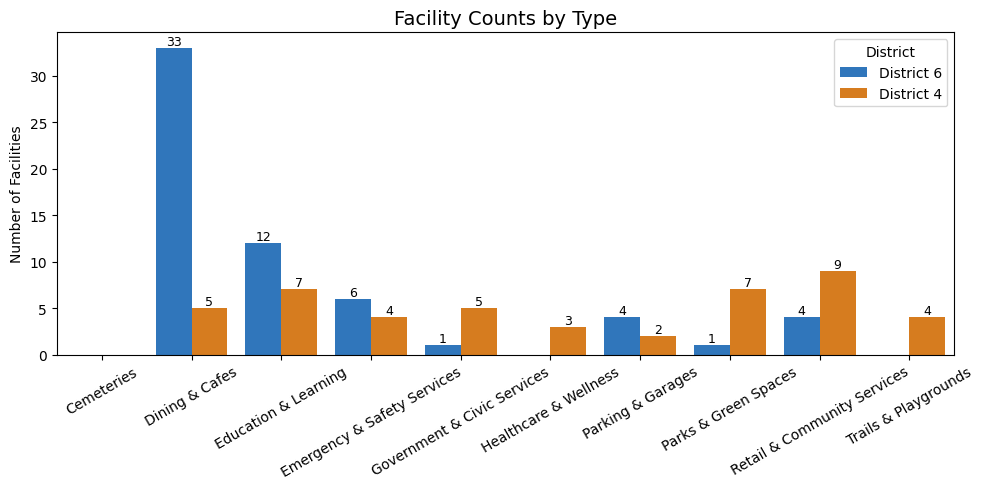

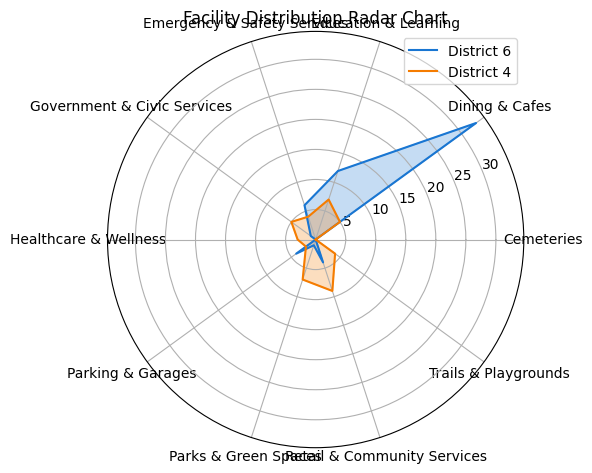

/var/folders/k9/zw6lvbj55kqd5yvrcc_n3f3r0000gn/T/ipykernel_12093/3339734391.py:146: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_data.set_index("Facility Group")[district_a].plot.pie(
/var/folders/k9/zw6lvbj55kqd5yvrcc_n3f3r0000gn/T/ipykernel_12093/3339734391.py:151: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_data.set_index("Facility Group")[district_b].plot.pie(


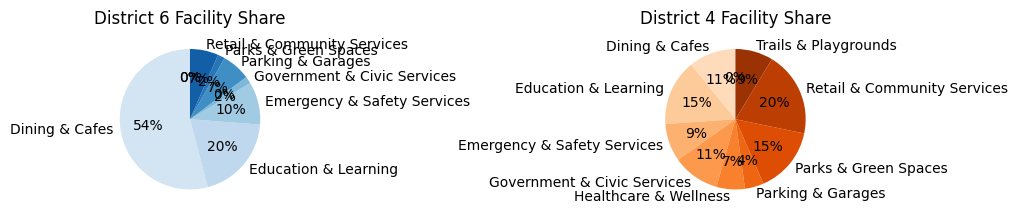

### 💡 Key Insight

District 4 offers fewer dining spots, education centers, emergency services, and parking facilities than District 6.

In [13]:
# -------------------- 1. Load Data --------------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from shapely import wkt
from IPython.display import display, Markdown, clear_output
from branca.colormap import LinearColormap

# Load district data
districts = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/City_Council_Districts.csv")
districts["geometry"] = districts["Geometry"].apply(wkt.loads)
gdf_dist = gpd.GeoDataFrame(districts, geometry="geometry", crs="EPSG:4326")
gdf_dist["Area_readable"] = (gdf_dist["Area (sq ft)"] / 1_000_000).round(1).astype(str) + " M"

# Load facilities data
facilities = pd.read_csv("/Users/mohammedpathariya/Docs/IUB Docs/Sem 2/Data Viz/BloomingtonCityFacilitiesProject/CityFacilitiesData/city_fac_bloomington_fully_cleaned_main.csv")
facilities_gdf = gpd.GeoDataFrame(
    facilities,
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude),
    crs="EPSG:4326"
)

# -------------------- 2. Assign Facilities to Districts --------------------
joined = gpd.sjoin(facilities_gdf, gdf_dist, how="left", predicate="within")
orphans = joined[joined.index_right.isna()].copy()

if not orphans.empty:
    gdf_proj = gdf_dist.to_crs(epsg=26916)
    orphans_proj = orphans.to_crs(epsg=26916)

    reassigned_idxs = []
    for idx, orphan in orphans_proj.iterrows():
        distances = gdf_proj.geometry.distance(orphan.geometry)
        nearest_idx = distances.idxmin()
        reassigned_idxs.append(nearest_idx)

    joined.loc[orphans.index, "index_right"] = reassigned_idxs

facilities_gdf["assigned_dist"] = joined["index_right"].astype(int)

# -------------------- 3. Prepare Facility Aggregations --------------------
facility_counts = facilities_gdf.groupby(["assigned_dist", "Facility Group"]).size().unstack(fill_value=0)
gdf_dist["facility_count"] = facilities_gdf["assigned_dist"].value_counts().reindex(gdf_dist.index).fillna(0).astype(int)
gdf_dist["density"] = gdf_dist["facility_count"] / gdf_dist["Area (sq ft)"]

# -------------------- 4. Prewritten Insights --------------------
insight_dict = {
    "District 1 vs District 2": "District 1 lags behind District 2 across several categories: cemeteries, dining spots, education, emergency services, civic offices, healthcare, parking, retail services, and playgrounds.",
    "District 1 vs District 3": "District 1 has fewer dining spots and emergency service facilities compared to District 3.",
    "District 1 vs District 4": "District 4 has fewer education centers, civic service offices, healthcare facilities, parking spaces, parks, and playgrounds compared to District 1.",
    "District 1 vs District 5": "District 1 offers fewer dining spots and emergency services than District 5.",
    "District 1 vs District 6": "District 6 has fewer civic offices, healthcare centers, parks, retail hubs, and playgrounds than District 1.",
    "District 2 vs District 3": "District 3 falls short of District 2 in cemeteries, dining spots, educational centers, emergency services, civic offices, healthcare services, parking spaces, parks, retail hubs, and playgrounds.",
    "District 2 vs District 4": "District 4 trails District 2 across multiple categories including cemeteries, dining, education, emergency services, civic services, healthcare, parking, parks, retail services, and playgrounds.",
    "District 2 vs District 5": "District 5 offers fewer facilities than District 2 across cemeteries, dining, education, emergency services, civic offices, healthcare, parking, parks, retail services, and playgrounds.",
    "District 2 vs District 6": "District 6 trails District 2 in cemeteries, education, emergency services, civic offices, healthcare, parking, parks, retail hubs, and playgrounds.",
    "District 3 vs District 4": "District 4 has fewer education and learning facilities and trails and playgrounds compared to District 3.",
    "District 3 vs District 5": "District 3 has fewer civic offices and parking facilities compared to District 5.",
    "District 3 vs District 6": "District 6 offers less access to healthcare services, parks, and playgrounds compared to District 3.",
    "District 4 vs District 5": "District 4 has fewer education centers, civic services, and recreational areas than District 5.",
    "District 4 vs District 6": "District 4 offers fewer dining spots, education centers, emergency services, and parking facilities than District 6.",
    "District 5 vs District 6": "District 6 has fewer civic offices, healthcare services, parks, and playgrounds than District 5."
}

def get_insight(d1, d2):
    key1 = f"{d1} vs {d2}"
    key2 = f"{d2} vs {d1}"
    return insight_dict.get(key1) or insight_dict.get(key2) or "No insight available."

def display_insight(d1, d2):
    insight_text = get_insight(d1, d2)
    display(Markdown("### 💡 Key Insight"))
    display(Markdown(insight_text))

# -------------------- 5. Widgets and Logic --------------------
district_options = gdf_dist["District"].tolist()
dropdown_a = widgets.Dropdown(options=district_options, description="District A:")
dropdown_b = widgets.Dropdown(options=district_options, description="District B:")
compare_btn = widgets.Button(description="Compare")

def compare_districts(district_a, district_b):
    clear_output(wait=True)

    a_idx = gdf_dist[gdf_dist["District"] == district_a].index[0]
    b_idx = gdf_dist[gdf_dist["District"] == district_b].index[0]

    def get_stats(idx):
        row = gdf_dist.loc[idx]
        return {
            "District": row["District"],
            "Area (M sq ft)": round(row["Area (sq ft)"] / 1_000_000, 2),
            "Total Facilities": int(row["facility_count"]),
            "Facility Density": round(row["density"], 8),
            **facility_counts.loc[idx].to_dict()
        }

    stats_a = get_stats(a_idx)
    stats_b = get_stats(b_idx)
    df_compare = pd.DataFrame([stats_a, stats_b]).T
    df_compare.columns = [district_a, district_b]

    display(Markdown(f"## 📊 Facility Comparison: {district_a} vs {district_b}"))
    display(df_compare)

    # ---- Bar Chart ----
    comp_data = df_compare.loc[facility_counts.columns].reset_index().rename(columns={"index": "Facility Group"})
    melted = pd.melt(comp_data, id_vars="Facility Group", var_name="District", value_name="Count")

    plt.figure(figsize=(10, 5))
    barplot = sns.barplot(data=melted, x="Facility Group", y="Count", hue="District", palette=["#1976d2", "#f57c00"])
    plt.title("Facility Counts by Type", fontsize=14)
    plt.ylabel("Number of Facilities")
    plt.xlabel("")
    plt.xticks(rotation=30)
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

    # ---- Radar Chart ----
    labels = facility_counts.columns.tolist()
    values_a = df_compare.loc[labels, district_a].tolist()
    values_b = df_compare.loc[labels, district_b].tolist()
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values_a += values_a[:1]
    values_b += values_b[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values_a, label=district_a, color="#1976d2")
    ax.fill(angles, values_a, alpha=0.25, color="#1976d2")
    ax.plot(angles, values_b, label=district_b, color="#f57c00")
    ax.fill(angles, values_b, alpha=0.25, color="#f57c00")
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Facility Distribution Radar Chart")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # ---- Pie Charts ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    comp_data.set_index("Facility Group")[district_a].plot.pie(
        ax=ax1, autopct="%1.0f%%", startangle=90, colors=sns.color_palette("Blues", len(labels)))
    ax1.set_ylabel("")
    ax1.set_title(f"{district_a} Facility Share")

    comp_data.set_index("Facility Group")[district_b].plot.pie(
        ax=ax2, autopct="%1.0f%%", startangle=90, colors=sns.color_palette("Oranges", len(labels)))
    ax2.set_ylabel("")
    ax2.set_title(f"{district_b} Facility Share")

    plt.tight_layout()
    plt.show()

    # ---- Insight Display ----
    display_insight(district_a, district_b)

compare_btn.on_click(lambda b: compare_districts(dropdown_a.value, dropdown_b.value))

display(Markdown("## 🔍 Select Two Districts for Comparison"))
display(widgets.HBox([dropdown_a, dropdown_b, compare_btn]))

In [14]:
districts

District ID    District  Area (sq ft)  \
0            4  District 4  8.553334e+07   
1            6  District 6  3.020599e+07   
2            1  District 1  1.342504e+08   
3            3  District 3  1.534440e+08   
4            5  District 5  1.088878e+08   
5            2  District 2  1.399302e+08   

                                            Geometry         Representative  \
0  MULTIPOLYGON (((-86.527306181621 39.1643244265...             Dave Rollo   
1  MULTIPOLYGON (((-86.509413176895 39.1642714268...          Sydney Zulich   
2  MULTIPOLYGON (((-86.587871200618 39.1646914235...  Isabel Piedmont-Smith   
3  MULTIPOLYGON (((-86.471944165717 39.1665614293...          Hopi Stosberg   
4  MULTIPOLYGON (((-86.496501171005 39.1355454216...         Courtney Daily   
5  MULTIPOLYGON (((-86.547340191361 39.2093394330...       Kate Rosenbarger   

   Established Year                                           geometry  
0              2024  MULTIPOLYGON (((-86.527306181621 39.1643244265...  
1              2024  MULTIPOLYGON (((-86.509413176895 39.1642714268...  
2              2024  MULTIPOLYGON (((-86.587871200618 39.1646914235...  
3              2024  MULTIPOLYGON (((-86.471944165717 39.1665614293...  
4              2024  MULTIPOLYGON (((-86.496501171005 39.1355454216...  
5              2024  MULTIPOLYGON (((-86.547340191361 39.2093394330...

In [15]:
facilities

Facility ID                                 Facility Name  \
0       C-C-001                            Rose Hill Cemetery   
1       C-C-002                            White Oak Cemetery   
2      DC-A-001                         Big Woods Bloomington   
3      DC-A-002                            Half Bottle Bistro   
4      DC-A-003                                          Hive   
..          ...                                           ...   
388    TP-T-031  Rev Ernest D Butler Park Southern Trail Head   
389    TP-T-032     Griffy Creek Trail Griffy Lake Trail Head   
390    TP-T-033            Griffy Creek Trail East Trail Head   
391    TP-T-034          Polly Grimshaw Trail East Trail Head   
392   TP-UG-001                                     Goat Farm   

           Facility Group           Facility Type  \
0              Cemeteries                Cemetery   
1              Cemeteries                Cemetery   
2          Dining & Cafes                American   
3          Dining & Cafes                American   
4          Dining & Cafes                American   
..                    ...                     ...   
388  Trails & Playgrounds               Trailhead   
389  Trails & Playgrounds               Trailhead   
390  Trails & Playgrounds               Trailhead   
391  Trails & Playgrounds               Trailhead   
392  Trails & Playgrounds  Undeveloped Greenspace   

                                               Address   Latitude  Longitude  \
0                   1100 W 4Th Street, Bloomington, IN  39.165708 -86.545797   
1                   1200 W 7Th Street, Bloomington, IN  39.169052 -86.548152   
2                  116 N Grant Street, Bloomington, IN  39.167131 -86.529590   
3                    3115 S Sare Road, Bloomington, IN  39.133184 -86.497784   
4                  2608 E 10Th Street, Bloomington, IN  39.170754 -86.501125   
..                                                 ...        ...        ...   
388  At W 9Th Street Across From N William Street, ...  39.170523 -86.543203   
389  East End Of The Griffy Lake Boathouse Parking ...  39.197789 -86.511654   
390  East End Of Griffy Creek Trail On The East Sid...  39.204914 -86.486520   
391  At E Longview Avenue And Glenwood Avenue W, Bl...  39.167989 -86.490172   
392               2000 E Winslow Road, Bloomington, IN  39.134041 -86.510097   

                                   Geometry  
0              POINT (-86.545797 39.165708)  
1              POINT (-86.548152 39.169052)  
2    POINT (-86.52958997532201 39.16713145)  
3    POINT (-86.49778373505043 39.13318445)  
4            POINT (-86.5011251 39.1707541)  
..                                      ...  
388            POINT (-86.543203 39.170523)  
389            POINT (-86.511654 39.197789)  
390             POINT (-86.48652 39.204914)  
391            POINT (-86.490172 39.167989)  
392            POINT (-86.510097 39.134041)  

[393 rows x 8 columns]

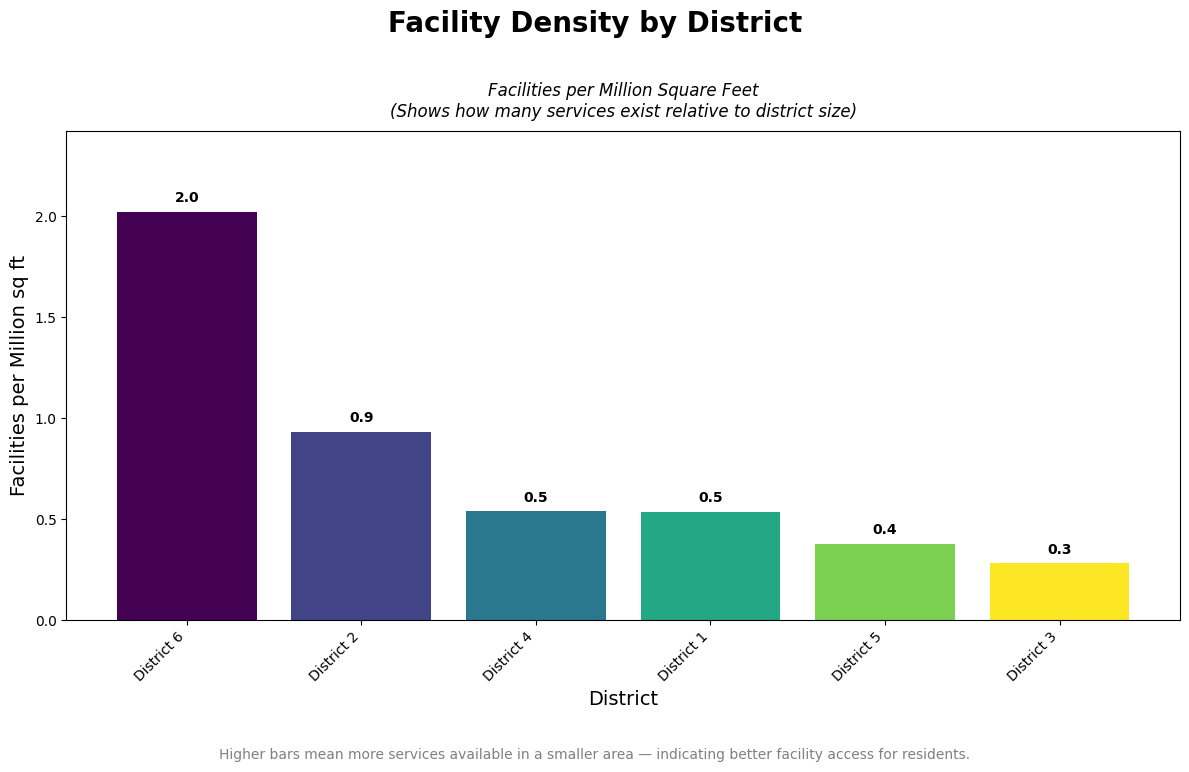

In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely import wkt

# ----------------------------
# 1. Facility Counts & Density
# ----------------------------
# Count facilities assigned to each district
facility_counts = facilities_gdf["assigned_dist"].value_counts().reindex(gdf_dist.index).fillna(0).astype(int)

# Add facility counts and density to district dataframe
gdf_dist["facility_count"] = facility_counts
gdf_dist["area_million_sqft"] = gdf_dist["Area (sq ft)"] / 1_000_000
gdf_dist["facility_density"] = gdf_dist["facility_count"] / gdf_dist["area_million_sqft"]

# Sort by density (optional for nicer bar order)
gdf_sorted = gdf_dist.sort_values(by="facility_density", ascending=False)

# ----------------------------
# 2. Plotting the Bar Chart
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# Color mapping based on Viridis colormap
norm = mcolors.Normalize(vmin=0, vmax=len(gdf_sorted)-1)
colors = [cm.viridis(norm(i)) for i in range(len(gdf_sorted))]

# Plot
bars = ax.bar(
    gdf_sorted["District"],
    gdf_sorted["facility_density"],
    color=colors
)

# Title and subtitle
plt.suptitle("Facility Density by District", fontsize=20, fontweight="bold", y=1.02)
plt.title(
    "Facilities per Million Square Feet\n(Shows how many services exist relative to district size)",
    fontsize=12,
    style="italic",
    y=1.01
)

# Axis labels
ax.set_xlabel("District", fontsize=14)
ax.set_ylabel("Facilities per Million sq ft", fontsize=14)

# Dynamic Y-axis scaling
ax.set_ylim(0, gdf_sorted["facility_density"].max() * 1.2)

# X-ticks
plt.xticks(rotation=45, ha="right")

# Remove gridlines
ax.grid(False)

# Value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),  # 5 points vertical offset
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
        fontweight="bold"
    )

# Footer explanation
fig.text(
    0.5,
    -0.05,
    "Higher bars mean more services available in a smaller area — indicating better facility access for residents.",
    ha="center",
    fontsize=10,
    color="gray"
)

# Tight layout for best spacing
plt.tight_layout()

# Save figure
plt.savefig("facility_density_by_district_final.png", dpi=300, bbox_inches="tight")

# Show
plt.show()

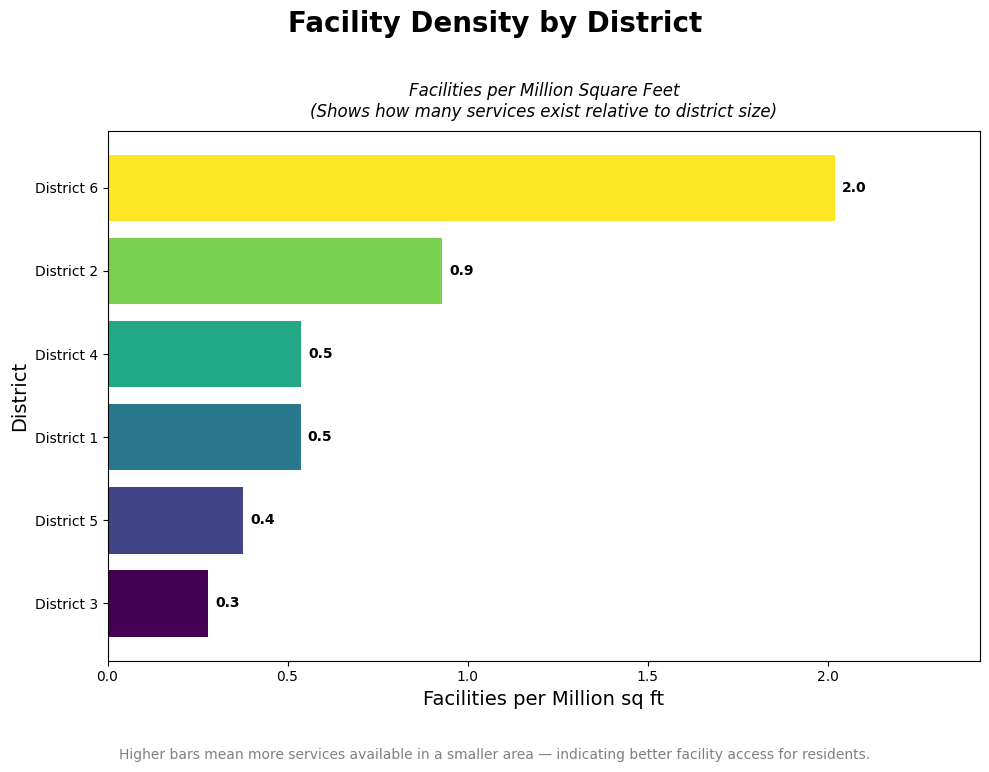

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely import wkt

# ----------------------------
# 1. Facility Counts & Density
# ----------------------------
# Count facilities assigned to each district
facility_counts = facilities_gdf["assigned_dist"].value_counts().reindex(gdf_dist.index).fillna(0).astype(int)

# Add facility counts and density to district dataframe
gdf_dist["facility_count"] = facility_counts
gdf_dist["area_million_sqft"] = gdf_dist["Area (sq ft)"] / 1_000_000
gdf_dist["facility_density"] = gdf_dist["facility_count"] / gdf_dist["area_million_sqft"]

# Sort by density (for better look)
gdf_sorted = gdf_dist.sort_values(by="facility_density", ascending=True)  # ascending for horizontal bars

# ----------------------------
# 2. Plotting the Horizontal Bar Chart
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 7))

# Color mapping (Viridis)
norm = mcolors.Normalize(vmin=0, vmax=len(gdf_sorted)-1)
colors = [cm.viridis(norm(i)) for i in range(len(gdf_sorted))]

# Plot
bars = ax.barh(
    gdf_sorted["District"],
    gdf_sorted["facility_density"],
    color=colors
)

# Title and subtitle
plt.suptitle("Facility Density by District", fontsize=20, fontweight="bold", y=1.02)
plt.title(
    "Facilities per Million Square Feet\n(Shows how many services exist relative to district size)",
    fontsize=12,
    style="italic",
    y=1.01
)

# Axis labels
ax.set_xlabel("Facilities per Million sq ft", fontsize=14)
ax.set_ylabel("District", fontsize=14)

# Dynamic X-axis scaling
ax.set_xlim(0, gdf_sorted["facility_density"].max() * 1.2)

# Remove gridlines
ax.grid(False)

# Value labels next to bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(
        f"{width:.1f}",
        xy=(width, bar.get_y() + bar.get_height() / 2),
        xytext=(5, 0),  # 5 points horizontal offset
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=10,
        color="black",
        fontweight="bold"
    )

# Footer explanation
fig.text(
    0.5,
    -0.05,
    "Higher bars mean more services available in a smaller area — indicating better facility access for residents.",
    ha="center",
    fontsize=10,
    color="gray"
)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("facility_density_by_district_horizontal.png", dpi=300, bbox_inches="tight")

# Show
plt.show()